In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2DTranspose, MaxPool2D, Flatten, Conv2D, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import Callback
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, UpSampling2D
from tensorflow.keras import backend as K
from keras.callbacks import EarlyStopping

from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Conv2DTranspose, Input
from tensorflow.keras.initializers import he_normal

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
plt.style.use("dark_background")

from sklearn.preprocessing import MaxAbsScaler
# from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
# scaler = MinMaxScaler(feature_range=(-1,1))

tf.random.set_seed(42)  # to replicate results

2024-08-01 11:02:07.059842: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 11:02:07.059890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 11:02:07.061126: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-01 11:02:07.067904: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-01 11:02:08.279062: W tensorflow/compiler/tf2

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  4


In [3]:
# Get the list of available physical GPUs
gpus = tf.config.list_physical_devices('GPU')

# Set memory growth for each GPU
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Create MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2024-08-01 11:02:11.713549: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79086 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2024-08-01 11:02:11.715147: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79086 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:44:00.0, compute capability: 8.0
2024-08-01 11:02:11.716578: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79086 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:84:00.0, compute capability: 8.0
2024-08-01 11:02:11.718009: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 79086 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-80GB, pci bu

In [4]:
diri = '/work/bb0983/athul_satheesh/e_obs_precip/'
diro = '/work/bb0983/athul_satheesh/downscaled_data/europe/figures/'

coarse_raw = 'rr_ens_mean_1.0deg_reg_v29.0e.nc'
fine_raw = 'rr_ens_mean_0.1deg_reg_v29.0e.nc'

lati = 43#40
latf = 59#60

loni = -6#-10
lonf = 15#30

strt = '1950-01-01'
last = '2023-12-31'

coarse_data = xr.open_dataset(diri+coarse_raw).rr.transpose('time','lat','lon').sel(time=slice(strt, last), 
                                                                                    lat=slice(lati, latf), 
                                                                                    lon=slice(loni, lonf))
fine_data = xr.open_dataset(diri+fine_raw).rr.transpose('time','latitude','longitude').sel(time=slice(strt, last), 
                                                                                           latitude=slice(lati, latf), 
                                                                                           longitude=slice(loni, lonf))
fine_data = fine_data.rename({'latitude':'lat', 'longitude':'lon'})

In [5]:
dims_coarse = coarse_data.shape
dims_fine = fine_data.shape

In [6]:
dims_coarse, dims_fine

((27028, 16, 21), (27028, 160, 210))

In [7]:
train_strt = strt
train_last = '2000-12-31'

test_strt = '2001-01-01'
test_last = last

coarse_data_train = coarse_data.sel(time=slice(train_strt, train_last))#.interp(lat=fine_data.lat, lon=fine_data.lon, method='linear')
# coarse_data_train = coarse_data_train.fillna(coarse_data_train.mean())
coarse_data_test = coarse_data.sel(time=slice(test_strt, test_last))#.interp(lat=fine_data.lat, lon=fine_data.lon, method='linear')
# coarse_data_test = coarse_data_test.fillna(coarse_data_test.mean())
# print(coarse_data_train.shape, coarse_data_test.shape)

fine_data_train = fine_data.sel(time=slice(train_strt, train_last))
fine_data_test = fine_data.sel(time=slice(test_strt, test_last))
# print(fine_data_train.shape, fine_data_test.shape)

In [8]:
coarse_nan_mask = np.isnan(coarse_data_test)
fine_nan_mask = np.isnan(fine_data_test)

fill_val = -1e-10

In [9]:
coarse_data_train = coarse_data_train.fillna(fill_val)#.interp(lat=fine_data.lat, lon=fine_data.lon, method='linear')
# coarse_data_train = coarse_data_train.fillna(coarse_data_train.mean())
coarse_data_test = coarse_data_test.fillna(fill_val)#.interp(lat=fine_data.lat, lon=fine_data.lon, method='linear')
# coarse_data_test = coarse_data_test.fillna(coarse_data_test.mean())
# print(coarse_data_train.shape, coarse_data_test.shape)

fine_data_train = fine_data_train.fillna(fill_val)
fine_data_test = fine_data_test.fillna(fill_val)
# print(fine_data_train.shape, fine_data_test.shape)

In [10]:
# def upsampling_block(inputs, filters, kernel_size, upsample_factor, name, dilation_rate, strides, use_batch_norm=True):
#     x = UpSampling2D(size=upsample_factor, name=name+'_upsample')(inputs)
#     x = Conv2D(filters, kernel_size, dilation_rate=dilation_rate, padding='same', strides=strides,
#                kernel_initializer=he_normal(), name=name+'_conv')(x)
#     x = LeakyReLU(alpha=0.2, name=name+'_lrelu')(x)
#     if use_batch_norm:
#         x = BatchNormalization(name=name+'_bn')(x)
#     return x

In [11]:
# def build_nn(input_shape, output_shape):
#     inputs = Input(shape=input_shape, name='input_layer')
    
#     # Adding upsampling blocks
#     x = upsampling_block(inputs, 128, (3, 3), (2, 2), 'upsample_1', dilation_rate=(1, 1), strides=(1, 1))
#     x = upsampling_block(x, 64, (3, 3), (2, 2), 'upsample_2', dilation_rate=(1, 1), strides=(1, 1))
#     x = upsampling_block(x, 32, (3, 3), (2, 2), 'upsample_3', dilation_rate=(1, 1), strides=(1, 1))
#     x = upsampling_block(x, 16, (3, 3), (5, 5), 'upsample_4', dilation_rate=(1, 1), strides=(2, 2))
    
#     outputs = Conv2D(filters=1, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu', name='final_conv')(x)
    
#     model = Model(inputs=inputs, outputs=outputs, name='cnn_downscaler')
    
#     return model

In [12]:
def build_nn(input_shape, output_shape):
    inputs = Input(shape=input_shape, name='input_layer')

    x = Conv2DTranspose(filters=2048, kernel_size=(3,3), strides=(1,1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
        
    x = Conv2DTranspose(filters=512, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
        
    x = Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
        
    x = Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    outputs = Conv2DTranspose(filters=1, kernel_size=(6,6), strides=(5,5), padding='same', activation='relu')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='tcnn_downscaler')
    
    return model

In [13]:
# def masked_mae(y_true, y_pred):
#     mask = K.cast(K.not_equal(y_true, -1), K.floatx())
#     loss = K.abs(y_true - y_pred)
#     masked_loss = loss * mask
#     return K.sum(masked_loss) / K.sum(mask)

In [14]:
input_shape  = coarse_data.shape[1:] + (1,)
output_shape = fine_data.shape[1:] + (1,)

with strategy.scope():

    nn = build_nn(input_shape, output_shape)
    lr = 3e-4
    nn.compile(optimizer=Adam(learning_rate=lr), loss='mae')
    # nn.compile(optimizer=Adam(learning_rate=lr), loss=masked_mae)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [15]:
nn.summary()

Model: "tcnn_downscaler"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 16, 21, 1)]       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 21, 2048)      20480     
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 16, 21, 2048)      8192      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 21, 2048)      0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 21, 512)       9437696   
 Transpose)                                                      
                                                   

In [16]:
class DisplayEpochProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 10 == 0:
            loss = "{:.5f}".format(logs['loss'])
            val_loss = "{:.5f}".format(logs['val_loss'])
            print(f"Epoch {epoch+1}, Loss: {loss}, val_loss: {val_loss}")

In [17]:
def issue_preds(model, coarse_data_train, fine_data_train, coarse_data_test, fine_data_test, epochs, batch_size):
    
    coarse_data_train = normalize_data(coarse_data_train, scaler)
    coarse_data_test = normalize_data(coarse_data_test, scaler, train=False)
    
    fine_data_train = normalize_data(fine_data_train, scaler)
    fine_data_test = normalize_data(fine_data_test, scaler, train=False)
           
    # print(coarse_data_train.shape)
    # print(fine_data_train.shape)

    # Define the EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, min_delta=1e-5, restore_best_weights=True)
    
    history = model.fit(x=coarse_data_train, y=fine_data_train,
                       epochs=epochs, batch_size=batch_size,
                       shuffle=True, validation_split=0.30, verbose=0,
                       callbacks=[DisplayEpochProgress(), early_stopping])
    pred = model.predict(x=coarse_data_test,).squeeze()    
    
    return pred

In [18]:
def normalize_data(dataset, scaler, train=True):
    
    dims = dataset.shape
    
    dataset = dataset.values.reshape(-1, dims[1]*dims[2])

    if train:
        normalized_data = scaler.fit_transform(dataset)
    else:
        normalized_data = scaler.transform(dataset)
        
    normalized_data = normalized_data.reshape(dims + (1,) ) # Make 4D
    
    return normalized_data#, scaler

In [19]:
epochs = 400
batch_size = 365

In [20]:
%%time
preds = issue_preds(nn, coarse_data_train, fine_data_train, coarse_data_test, fine_data_test, epochs, batch_size)
nn.save(f'/work/bb0983/athul_satheesh/downscaled_data/europe/trained_models/tcnn.keras')
# del nn

INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-08-01 11:03:00.215933: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-08-01 11:03:00.223228: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-08-01 11:03:00.234477: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-08-01 11:03:00.247313: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-08-01 11:03:00.338355: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-01 11:03:02.136607: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-01 11:03:06.922035: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff0fe7d6f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-01 11:03:06.922071: I external/loc

Epoch 10, Loss: 0.00997, val_loss: 0.02759
Epoch 20, Loss: 0.00855, val_loss: 0.01174
Epoch 30, Loss: 0.00796, val_loss: 0.00858
Epoch 40, Loss: 0.00777, val_loss: 0.00842
Epoch 50, Loss: 0.00762, val_loss: 0.00823
Epoch 60, Loss: 0.00749, val_loss: 0.00813
Epoch 70, Loss: 0.00744, val_loss: 0.00806
Epoch 80, Loss: 0.00738, val_loss: 0.00810
Epoch 90, Loss: 0.00732, val_loss: 0.00797
Epoch 100, Loss: 0.00730, val_loss: 0.00800
Epoch 110, Loss: 0.00726, val_loss: 0.00798
Epoch 120, Loss: 0.00724, val_loss: 0.00790
Epoch 130, Loss: 0.00719, val_loss: 0.00787
Epoch 140, Loss: 0.00717, val_loss: 0.00789
Epoch 150, Loss: 0.00714, val_loss: 0.00789
Epoch 160, Loss: 0.00711, val_loss: 0.00786
Epoch 170, Loss: 0.00713, val_loss: 0.00782
Epoch 180, Loss: 0.00707, val_loss: 0.00784
Epoch 190, Loss: 0.00710, val_loss: 0.00794
Epoch 200, Loss: 0.00706, val_loss: 0.00782
Epoch 210, Loss: 0.00703, val_loss: 0.00780
Epoch 220, Loss: 0.00705, val_loss: 0.00784
Epoch 230, Loss: 0.00699, val_loss: 0.007

In [21]:
def inverse_normalize_data(normalized_data, scaler):
    
    dims = normalized_data.shape
    
    normalized_data = normalized_data.reshape(-1, dims[1]*dims[2])
    
    original_data = scaler.inverse_transform(normalized_data)
    
    original_data = original_data.reshape(dims)
    return original_data

In [22]:
downscaled_data = inverse_normalize_data(preds, scaler)

In [23]:
downscaled_data.shape

(8400, 160, 210)

In [24]:
downscaled_data = xr.DataArray(name='precipitation', data=downscaled_data, dims=fine_data_test.dims, coords=fine_data_test.coords, attrs=fine_data_test.attrs)

In [25]:
# downscaled_data = xr.where(downscaled_data>=0, downscaled_data, np.nan)
# fine_data_test = xr.where(fine_data_test>=0, fine_data_test, np.nan)
# coarse_data_test = xr.where(coarse_data_test>=0, coarse_data_test, np.nan)

downscaled_data = downscaled_data.where(~fine_nan_mask, np.nan)
fine_data_test = fine_data_test.where(~fine_nan_mask, np.nan)
coarse_data_test = coarse_data_test.where(~coarse_nan_mask, np.nan)

In [26]:
diro = '/work/bb0983/athul_satheesh/downscaled_data/europe/downscaled_data/'
downscaled_data.to_netcdf(diro + 'e_obs_eu_downscaled_cnnT.nc')

In [32]:
date1 = '2014-06-09'
date2 = '2014-06-09'

print(f"MAE: {abs(fine_data_test - downscaled_data).mean().values:.4f}")
print(f"RMSE: {np.sqrt( ( (fine_data_test - downscaled_data)**2 ).mean() ).values:.4f}")

MAE: 0.9486
RMSE: 2.5875


In [28]:
# np.corrcoef(fine_data_test.values.flatten(), downscaled_data.values.flatten())[0,1]

In [29]:
from sklearn.metrics import r2_score
def compute_r2_with_nans(y_true, y_pred):
    # Mask for non-NaN values
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    
    # Filter out NaN values
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    # Compute R2 score
    r2 = r2_score(y_true_filtered, y_pred_filtered)
    return r2
r2 = compute_r2_with_nans(fine_data_test.values.flatten(), downscaled_data.values.flatten())
r2

0.761357171375596

In [30]:
# figs, axx = plt.subplots(figsize=(8,6))
# axx.scatter(fine_data_test.values.flatten(), downscaled_data.values.flatten(), s=0.1, alpha=0.9, color='C0')
# axx.plot([0,1000], [0,1000], color='red', alpha=0.9, zorder=1, ls='--')
# axx.set_xlim(-8,500)
# axx.set_ylim(-8,500)
# axx.set_xlabel('Observation', size=15)
# axx.set_ylabel('Downscaled', size=15)
# axx.text(45,400,f'$R^2: {r2:.2f}$', color='white', size=12)
# axx.grid(True, alpha=0.2, color='C1')

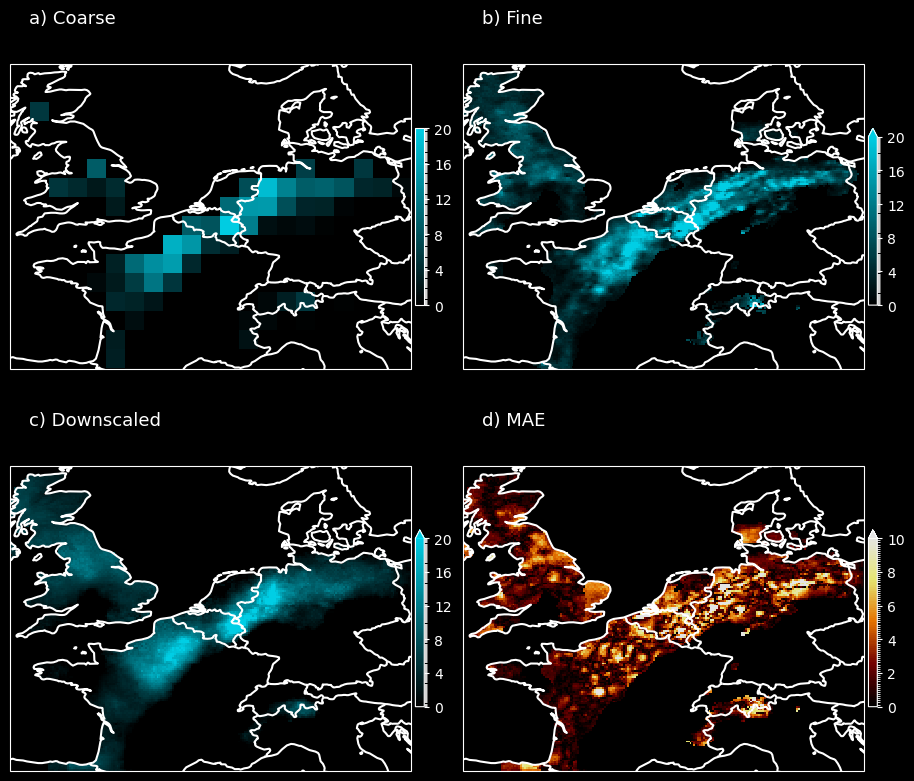

In [34]:
# Define the colormap colors
colors_blues2black = [(0, 0, 0), (0, 0.90, 1)]  # Blue to Black
colors_RdBlBu = [(1, 0, 0), (0, 0, 0), (0, 0.90, 1)]  # Blue to Black

# Create the colormap
cmap_name = 'BluesToBlack'
blues_to_black = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors_blues2black)
Rd_bl_Bu = mcolors.LinearSegmentedColormap.from_list('RdBlBu', colors_RdBlBu)


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10), sharex=True, sharey=True,
                        subplot_kw=dict(projection=ccrs.PlateCarree(), facecolor='black'),
                        gridspec_kw={'wspace': -0.05, 'hspace': 0.09})

# plots = [coarse_data_test, fine_data_test, downscaled_data, (fine_data_test - downscaled_data)]
plots = [coarse_data_test, fine_data_test, downscaled_data, abs(fine_data_test - downscaled_data)]
cmap = [blues_to_black, blues_to_black, blues_to_black, 'afmhot']
# cmap = [blues_to_black, blues_to_black, blues_to_black, Rd_bl_Bu]
# levels = [np.arange(0,30.25,0.25), np.arange(0,30.25,0.25), np.arange(0,30.25,0.25), np.arange(-12,12.25,0.25)]
levels = [np.arange(0,20.125,0.125), np.arange(0,20.125,0.125), np.arange(0,20.125,0.125), np.arange(0,10.125,0.125)]
# title = ['a) Coarse','b) Fine','c) Downscaled','d) Observed-Downscaled']
title = ['a) Coarse','b) Fine','c) Downscaled','d) MAE']
# ticks = [np.arange(0,33,3), np.arange(0,33,3), np.arange(0,33,3), np.arange(-12,13,4)]
ticks = [np.arange(0,24,4), np.arange(0,24,4), np.arange(0,24,4), np.arange(0,12,2)]

for i, ax in enumerate(axs.flatten()):
    plots[i].sel(time=slice(date1, date2)).mean('time').plot(cmap=cmap[i], levels=levels[i], 
                                                             ax=ax, cbar_kwargs={'orientation':'vertical',
                                                                                'pad':0.01, 'label':'',
                                                                                'shrink':0.48, 'drawedges':False,
                                                                                'ticks': ticks[i], },
                                                            alpha=0.90)
    
    ax.text(-5, 61.2, f'{title[i]}',size=13, color='white')
    ax.coastlines(linewidth=1.5, color='white')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1.5, edgecolor='white');
    ax.patch.set_facecolor('black')
plt.show()